# Import Necessary Packages

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Loading the data

In [39]:
train_df = pd.read_csv(os.path.join('data', 'train_data.csv'))

In [40]:
train_df.head(5)

,Tracking,date expédition,date première tentative,date livraison/échec,date dernier statut,ID expediteur,depart commune,depart wilaya,stop desk?,destination commune,destination wilaya,dernier statut
0,yal-ABC240400,2024-01-10 18:18:53,2024-01-12 16:46:52,2024-01-12 16:46:52,2024-01-12 16:46:52,expyal-11571,Oued Smar,Alger,oui,El Menia,Ghardaïa,Livré
1,yal-ABC089640,2024-01-04 18:55:07,2024-01-05 14:50:19,2024-01-05 14:50:19,2024-01-05 14:50:19,expyal-95,Oued Smar,Alger,non,Médéa,Médéa,Livré
2,yal-ABC004222,2024-01-02 16:47:55,2024-01-04 08:39:02,2024-01-05 09:47:54,2024-01-05 09:47:54,expyal-571,Taher,Jijel,oui,Tizi Ouzou,Tizi Ouzou,Livré
3,yal-ABC003797,2024-01-01 17:27:33,2024-01-02 10:10:15,2024-01-02 10:14:20,2024-01-02 10:14:20,expyal-13280,Cheraga,Alger,non,Tlemcen,Tlemcen,Livré
4,yal-ABC132873,2024-01-07 14:45:47,2024-01-08 10:49:38,2024-01-08 10:49:38,2024-01-08 10:49:38,expyal-1623,Khenchela,Khenchela,non,Bordj Bou Arreridj,Bordj Bou Arreridj,Livré


In [41]:
train_df.sample(3)

,Tracking,date expédition,date première tentative,date livraison/échec,date dernier statut,ID expediteur,depart commune,depart wilaya,stop desk?,destination commune,destination wilaya,dernier statut
70259,yal-ABC313510,2024-01-14 16:26:01,2024-01-15 15:37:56,2024-01-15 15:37:56,2024-01-15 15:37:56,expyal-2254,Reghaïa,Alger,oui,Chlef,Chlef,Livré
201204,yal-ABC302023,2024-01-14 15:40:36,2024-01-15 12:27:01,2024-01-17 12:39:45,2024-01-17 12:39:45,expyal-1769,Cheraga,Alger,non,Constantine,Constantine,Livré
117584,yal-ABC254944,2024-01-14 12:54:17,2024-01-16 13:36:40,2024-01-16 13:36:40,2024-01-16 13:36:40,expyal-3673,Akbou,Béjaïa,oui,Sidi Bel Abbes,Sidi Bel Abbès,Livré


# Data cleaning & preprocessing

#### Duplicated rows count

In [42]:
print(f'Number of duplicated rows: {train_df.duplicated().sum()}')

Number of duplicated rows: 0


#### Missing values count

In [43]:
train_df.isnull().sum()

Tracking                      0
date expédition               0
date première tentative    1121
date livraison/échec       1149
date dernier statut           0
ID expediteur                 0
depart commune                0
depart wilaya                 0
stop desk?                    0
destination commune           0
destination wilaya            0
dernier statut                0
dtype: int64

#### Unify different wilayas words

In [44]:
depart_mapping_dict = {
    'depart wilaya': {
        'Alger': 'Algiers',
        'Béjaïa': 'Bejaïa',
        'Aïn Témouchent': 'Aïn Temouchent',
        'Boumerdès' : 'Boumerdes',
        'Tipaza' : 'Tipasa',
        "M'Sila" : "M’Sila",
        "Oum El Bouaghi" : "Oum el Bouaghi",
        "Naâma" : "Naama"
    }
}
dest_mapping_dict = {
    'destination wilaya': {
        'Alger': 'Algiers',
        'Béjaïa': 'Bejaïa',
        'Aïn Témouchent': 'Aïn Temouchent',
        'Boumerdès' : 'Boumerdes',
        'Tipaza' : 'Tipasa',
        "M'Sila" : "M’Sila",
        "Oum El Bouaghi" : "Oum el Bouaghi",
        "Naâma" : "Naama"
    }
}

In [45]:
train_df.replace(depart_mapping_dict, inplace=True)
train_df.replace(dest_mapping_dict, inplace=True)

#### Grouping the status labels in 3 classes

In [46]:
status_mapping = {
    'Livré': 'Livré',
    'Retourné au vendeur': 'Retourné au vendeur',
    'Transfert': 'Expédié',
    'Retour à retirer': 'Retourné au vendeur',
    'Vers Wilaya': 'Expédié',
    'Retour groupé': 'Retourné au vendeur',
    'En localisation': 'Expédié',
    'Centre': 'Expédié',
    'Expédié': 'Expédié',
    'Reçu à Wilaya': 'Expédié',
    'Retour vers centre': 'Expédié',
    'Retourné au centre': 'Retourné au vendeur'
}

train_df['dernier statut'] = train_df['dernier statut'].map(status_mapping)

In [47]:
train_df['dernier statut'].value_counts()

dernier statut
Livré                  236293
Retourné au vendeur     34220
Expédié                   968
Name: count, dtype: int64

#### Compute the time differences

In [48]:
train_df['date expédition'] = pd.to_datetime(train_df['date expédition'])
train_df['date première tentative'] = pd.to_datetime(train_df['date première tentative'])
train_df['date livraison/échec'] = pd.to_datetime(train_df['date livraison/échec'])
train_df['date dernier statut'] = pd.to_datetime(train_df['date dernier statut'])

In [49]:
train_df['first_delivery_time'] = (train_df['date première tentative'] - train_df['date expédition']).dt.total_seconds() / 3600

In [50]:
train_df['pending_time'] = (train_df['date livraison/échec'] - train_df['date première tentative']).dt.total_seconds() / 3600

In [51]:
train_df['last_status_time'] = (train_df['date dernier statut'] - train_df['date livraison/échec']).dt.total_seconds() / 3600

#### Compute the frequency of shippers

In [52]:
train_df['expediteur_freq'] = train_df['ID expediteur'].map(train_df['ID expediteur'].value_counts())

#### Droping irrelevant columns

In [53]:
train_df = train_df.drop(['ID expediteur', 'Tracking','date expédition', 'date première tentative', 'date livraison/échec', 'date dernier statut'], axis=1)

In [54]:
train_df.head()

,depart commune,depart wilaya,stop desk?,destination commune,destination wilaya,dernier statut,first_delivery_time,pending_time,last_status_time,expediteur_freq
0,Oued Smar,Algiers,oui,El Menia,Ghardaïa,Livré,46.466389,0.000000,0.0,89
1,Oued Smar,Algiers,non,Médéa,Médéa,Livré,19.920000,0.000000,0.0,199
2,Taher,Jijel,oui,Tizi Ouzou,Tizi Ouzou,Livré,39.851944,25.147778,0.0,38
3,Cheraga,Algiers,non,Tlemcen,Tlemcen,Livré,16.711667,0.068056,0.0,35
4,Khenchela,Khenchela,non,Bordj Bou Arreridj,Bordj Bou Arreridj,Livré,20.064167,0.000000,0.0,74


#### Label Encoding

In [55]:
label_encoder = LabelEncoder()
train_df['depart wilaya'] = label_encoder.fit_transform(train_df['depart wilaya'])
train_df['destination wilaya'] = label_encoder.fit_transform(train_df['destination wilaya'])
train_df['depart commune'] = label_encoder.fit_transform(train_df['depart commune'])
train_df['destination commune'] = label_encoder.fit_transform(train_df['destination commune'])
train_df['stop desk?'] = label_encoder.fit_transform(train_df['stop desk?'])

In [56]:
train_df.head() 

,depart commune,depart wilaya,stop desk?,destination commune,destination wilaya,dernier statut,first_delivery_time,pending_time,last_status_time,expediteur_freq
0,87,1,1,592,19,Livré,46.466389,0.000000,0.0,89
1,87,1,0,907,28,Livré,19.920000,0.000000,0.0,199
2,101,22,1,1319,45,Livré,39.851944,25.147778,0.0,38
3,39,1,0,1322,46,Livré,16.711667,0.068056,0.0,35
4,71,23,0,303,9,Livré,20.064167,0.000000,0.0,74


In [845]:
# Detect outliers
train_df.describe()

,depart commune,depart wilaya,stop desk?,destination commune,destination wilaya,first_delivery_time,pending_time,last_status_time,expediteur_freq
count,271481.000000,271481.000000,271481.000000,271481.000000,271481.000000,270360.000000,270332.000000,270332.000000,271481.000000
mean,58.248459,14.024690,0.533750,659.891908,21.045325,36.745926,16.552374,22.965996,1653.020451
std,29.989824,15.190328,0.498861,407.222462,15.227218,28.449862,27.075329,67.850643,4373.668497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.005556,0.000000,-12.736667,1.000000
25%,34.000000,1.000000,0.000000,305.000000,6.000000,19.920000,0.000000,0.000000,24.000000
50%,60.000000,7.000000,1.000000,603.000000,20.000000,24.508750,1.590556,0.000000,81.000000
75%,87.000000,31.000000,1.000000,1022.000000,34.000000,45.214514,25.193611,0.000000,291.000000
max,115.000000,47.000000,1.000000,1364.000000,47.000000,718.971389,585.868889,700.562500,17384.000000


In [57]:
X = train_df.drop('dernier statut', axis=1)
y = train_df['dernier statut']

#### Impute missing values

In [58]:
dff = X
imputer = IterativeImputer(random_state=0)
imputed_df = imputer.fit_transform(dff)
imputed_df = pd.DataFrame(imputed_df, columns=dff.columns)
XX = imputed_df

In [59]:
XX.shape

(271481, 9)

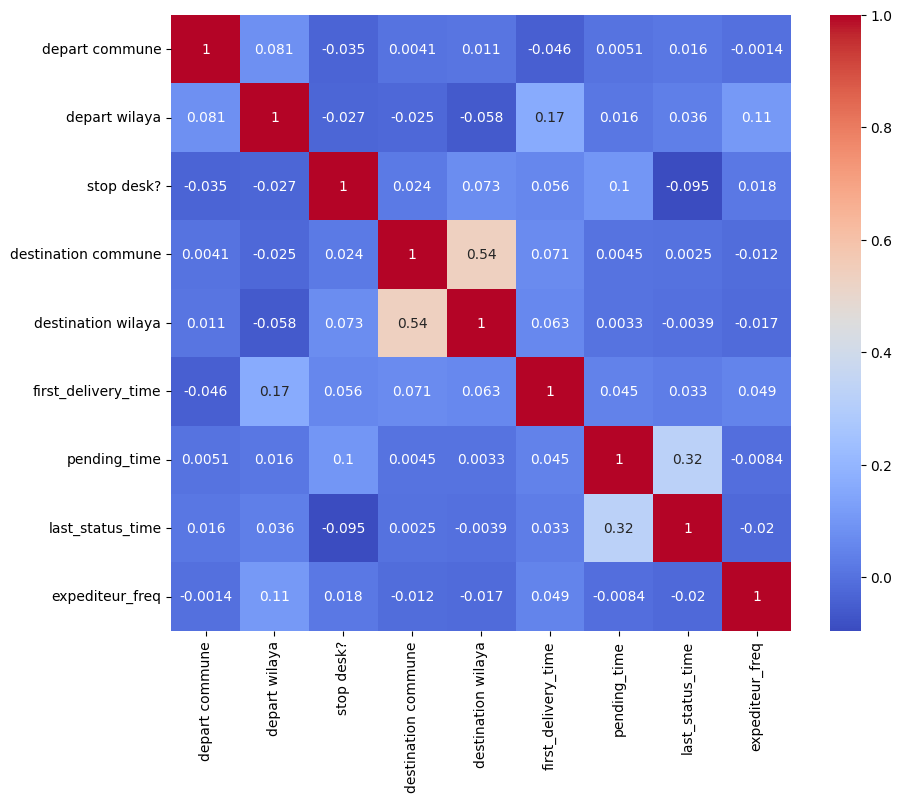

In [65]:
corr_matrix = XX.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Training & Evaluation

#### Data splitting

In [66]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=42)

#### Setting up the models

In [73]:
Models = [
    Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression())
    ]),
    Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier())
    ]),
    Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier())
    ]),
]
Models_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

#### Train the models

In [74]:
for index, model in enumerate(Models):
    print(f"Training the: {Models_names[index]} model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f" • Train accuracy: {accuracy_score(y_test, y_pred)}")
    print(f" • Train f1_score: {f1_score(y_test, y_pred, average='macro')}")

print('Done!')

Training the: Logistic Regression model...
 • Train accuracy: 0.9903309575114647
 • Train f1_score: 0.6567953880805817
Training the: Decision Tree model...
 • Train accuracy: 0.9989318010203142
 • Train f1_score: 0.9715993872245718
Training the: Random Forest model...
 • Train accuracy: 0.9990975560344034
 • Train f1_score: 0.9747453539753645
Done!


# Testing the model

#### Loading the test set

In [80]:
test_df = pd.read_csv("data/test.csv")

#### Preprocessing

In [81]:
test_df.isnull().sum()

Tracking                     0
date expédition              0
date première tentative    288
date livraison/échec       296
date dernier statut          0
ID expediteur                0
depart commune               0
depart wilaya                0
stop desk?                   0
destination commune          0
destination wilaya           0
dtype: int64

In [82]:
test_df.replace(depart_mapping_dict, inplace=True)
test_df.replace(dest_mapping_dict, inplace=True)

In [83]:
test_df['date expédition'] = pd.to_datetime(test_df['date expédition'])
test_df['date dernier statut'] = pd.to_datetime(test_df['date dernier statut'])
test_df['date première tentative'] = pd.to_datetime(test_df['date première tentative'])
test_df['date livraison/échec'] = pd.to_datetime(test_df['date livraison/échec'])


In [84]:
test_df['first_delivery_time'] = (test_df['date première tentative'] - test_df['date expédition']).dt.total_seconds() / 3600

In [85]:
test_df['pending_time'] = (test_df['date livraison/échec'] - test_df['date première tentative']).dt.total_seconds() / 3600

In [86]:
test_df['last_status_time'] = (test_df['date dernier statut'] - test_df['date livraison/échec']).dt.total_seconds() / 3600

In [87]:
test_df = test_df.drop(['Tracking', 'ID expediteur', 'date expédition', 'date première tentative', 'date livraison/échec', 'date dernier statut'], axis=1)

In [88]:
test_df.isna().sum()

depart commune           0
depart wilaya            0
stop desk?               0
destination commune      0
destination wilaya       0
first_delivery_time    288
pending_time           296
last_status_time       296
dtype: int64

In [89]:
test_df.head()

,depart commune,depart wilaya,stop desk?,destination commune,destination wilaya,first_delivery_time,pending_time,last_status_time
0,Bou Saâda,M’Sila,non,Les Eucalyptus,Algiers,47.551389,0.000000,0.0
1,El Eulma,Sétif,non,Tazoult,Batna,49.431667,0.000000,0.0
2,Oued Smar,Algiers,non,Saïda,Saïda,16.350000,0.000000,0.0
3,Oued Smar,Algiers,non,Annaba,Annaba,17.649444,0.000000,0.0
4,Oued Smar,Algiers,non,Aïn El Hadjel,M’Sila,16.803889,5.763889,0.0


In [90]:
label_encoder = LabelEncoder()
test_df['depart wilaya'] = label_encoder.fit_transform(test_df['depart wilaya'])
test_df['destination wilaya'] = label_encoder.fit_transform(test_df['destination wilaya'])
test_df['depart commune'] = label_encoder.fit_transform(test_df['depart commune'])
test_df['destination commune'] = label_encoder.fit_transform(test_df['destination commune'])
test_df['stop desk?'] = label_encoder.fit_transform(test_df['stop desk?'])

In [94]:
df = pd.read_csv("data/test.csv")

In [95]:
test_df.isna().sum()

depart commune           0
depart wilaya            0
stop desk?               0
destination commune      0
destination wilaya       0
first_delivery_time    288
pending_time           296
last_status_time       296
dtype: int64

In [96]:
test_df.shape , df.shape

((67871, 8), (67871, 11))

In [97]:
merged_df = pd.concat([X, test_df], axis=0)
imputer = IterativeImputer(random_state=0)
imputed_df = imputer.fit_transform(merged_df)
imputed_df = pd.DataFrame(imputed_df, columns=merged_df.columns)
test_df = imputed_df.iloc[X.shape[0]:, :]

In [98]:
test_df.shape

(67871, 9)

In [99]:
test_df.isna().sum()

depart commune         0
depart wilaya          0
stop desk?             0
destination commune    0
destination wilaya     0
first_delivery_time    0
pending_time           0
last_status_time       0
expediteur_freq        0
dtype: int64

#### Predict the labels on the test set

In [100]:
submit = pd.DataFrame()
submit['Tracking'] = df['Tracking']
y_pred = Models[2].fit(XX, y).predict(test_df)
submit['dernier statut'] = y_pred

In [102]:
submit.value_counts()

Tracking       dernier statut     
yal-ABC000004  Livré                  1
yal-ABC227502  Livré                  1
yal-ABC227429  Retourné au vendeur    1
yal-ABC227438  Retourné au vendeur    1
yal-ABC227444  Retourné au vendeur    1
                                     ..
yal-ABC113910  Retourné au vendeur    1
yal-ABC113919  Retourné au vendeur    1
yal-ABC113935  Livré                  1
yal-ABC113937  Livré                  1
yal-ABC349558  Retourné au vendeur    1
Name: count, Length: 67871, dtype: int64

In [103]:
submit['dernier statut'].unique()

array(['Livré', 'Retourné au vendeur'], dtype=object)

In [104]:
submit['dernier statut'].value_counts()

dernier statut
Livré                  59119
Retourné au vendeur     8752
Name: count, dtype: int64

In [822]:
submit.to_csv("submit.csv", index=False)